In [329]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [330]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=4c1790ad4360739e821cafddd9025858d9d2b1111e03704cc42dbbcfc37d8b00
  Stored in directory: /root/.cache/pip/wheels/8b/74/a8/df86fd600a6c68547019383b14765e2213085feb1a2fbf0db1
Successfully built colormath


MOUNT THE DRIVE AND LOAD THE DATASET

In [331]:
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

from colormath.color_objects import LCHabColor, sRGBColor
from colormath.color_conversions import convert_color

In [332]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

import numpy as np

In [333]:
#general variables
n_epochs=10
cycle_lambda = 10.
root_data = "lch_database"

In [334]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [335]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
'archive(4).zip'
'Copy of cycleGAN_CH.ipynb'
 CycleGAN.ipynb
 cycleGAN_patches.ipynb
 for_patches.jpg
 for_test_2.png
 for_test.png
 lch_database/
 LCH_UTILS.ipynb
 loss_functions/
 Models/
 notebooks_utils/
 not_so_straight_and_narrow_by_organicvision_degbboy-fullview.jpg
 result_analog.png
 wassersteinCycleGAN.ipynb


In [377]:
def lch_to_rgb(img,wasByte):
  new_img = np.zeros(img.shape)
  ctr=0
  if img.shape[2]!=3:
    print("warning : image is not in :,:,3 format !")
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pixel = img[i,j]
      lch = LCHabColor(pixel[0],pixel[1],pixel[2]/(256./360) if wasByte else pixel[2])
      rgb = convert_color(lch,sRGBColor)
      new_img[i,j]=np.array([rgb.rgb_r,rgb.rgb_g,rgb.rgb_b])
      ctr+=1
      if ctr%10000==0:
        print("converting image to rgb, did",ctr,"pixels")
  return new_img

def h_to_rgb(img,wasByte):
  new_img = np.zeros((img.shape[0],img.shape[1],3))
  ctr=0
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pixel = img[i,j]
      lch = LCHabColor(60,60,pixel/(256./360) if wasByte else pixel)
      rgb = convert_color(lch,sRGBColor)
      new_img[i,j]=np.array([rgb.rgb_r,rgb.rgb_g,rgb.rgb_b])
      ctr+=1
      if ctr%10000==0:
        print("converting image to rgb, did",ctr,"pixels")
  return new_img

def rgb_to_lch(img,forModel):
  new_img = np.zeros(img.shape)
  ctr=0
  if img.shape[2]!=3:
    print("warning : image is not in :,:,3 format !")
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pixel = img[i,j]
      rgb = sRGBColor(pixel[0]/255.,pixel[1]/255.,pixel[2]/255.)
      lch = convert_color(rgb,LCHabColor)
      new_img[i,j]=np.array([lch.lch_l,lch.lch_c,lch.lch_h*(256./360) if forModel else lch.lch_h])
      ctr+=1
      if ctr%10000==0:
        print("converting image to lch, did",ctr,"pixels")
  return new_img

##relu function :

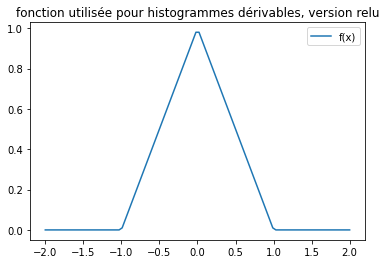

In [170]:
def f_rel(x,center,width):
  return 2./width*torch.relu(width/2-torch.abs(x-center))

x = torch.linspace(-2,2,100)
x.requires_grad_(True)
ff=f_rel(x,0,2)

plt.title("fonction utilisée pour histogrammes dérivables, version relu")
plt.plot(x.detach(),ff.detach(),label='f(x)')
plt.legend()

##sigmoid function :

tensor([ 2.0000,  1.9596,  1.9192,  1.8788,  1.8384,  1.7980,  1.7576,  1.7172,
         1.6768,  1.6364,  1.5960,  1.5557,  1.5154,  1.4751,  1.4349,  1.3948,
         1.3548,  1.3152,  1.2758,  1.2369,  1.1987,  1.1614,  1.1253,  1.0909,
         1.0585,  1.0288,  1.0024,  0.9798,  0.9619,  0.9491,  0.9420,  0.9408,
         0.9455,  0.9558,  0.9710,  0.9902,  1.0119,  1.0350,  1.0578,  1.0791,
         1.0974,  1.1118,  1.1214,  1.1255,  1.1238,  1.1158,  1.1014,  1.0806,
         1.0533,  1.0194,  0.9790,  0.9320,  0.8786,  0.8186,  0.7522,  0.6793,
         0.6003,  0.5154,  0.4250,  0.3297,  0.2306,  0.1285,  0.0249, -0.0790,
        -0.1816, -0.2815, -0.3775, -0.4686, -0.5542, -0.6338, -0.7075, -0.7755,
        -0.8383, -0.8966, -0.9510, -1.0021, -1.0505, -1.0969, -1.1416, -1.1851,
        -1.2277, -1.2697, -1.3111, -1.3522, -1.3931, -1.4338, -1.4744, -1.5149,
        -1.5554, -1.5959, -1.6363, -1.6767, -1.7172, -1.7576, -1.7980, -1.8384,
        -1.8788, -1.9192, -1.9596, -2.00

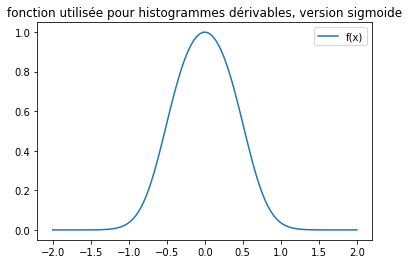

In [171]:
def f_sig(x,center,width):
  return 2.*torch.sigmoid(-torch.pow(x-center,2)*8/width)

x = torch.linspace(-2,2,100)
x.requires_grad_(True)
ff=f_sig(x,0,2)
ff.retain_grad()
ff.backward(ff-x)
print(ff.grad)
plt.title("fonction utilisée pour histogrammes dérivables, version sigmoide")
plt.plot(x.detach(),ff.detach(),label='f(x)')
plt.legend()

In [172]:
x = torch.Tensor([3,3,3,3,3,0,0,3])
print(f_sig(x,0,1).sum())

tensor(2.)


##histogram function :

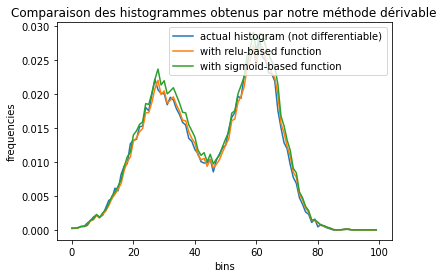

In [175]:
#x here being a 1D tensor
def hist_fun(method,x,width,nb_bins):
  valArrays=[]
  for bin in range(nb_bins):
    val=method(x,bin,width).sum()
    valArray = torch.zeros((nb_bins,))
    valArray[bin]+=val
    valArrays.append(valArray)
    
  return torch.sum(torch.stack(valArrays),1)

x = torch.concat([torch.tensor(np.random.randn(10000)*10+np.random.randint(100))*(3/4),torch.tensor(np.random.randn(10000)*10+np.random.randint(100))])
x.requires_grad_()
hist_rel = hist_fun(f_rel,x,2,100)/torch.numel(x)
hist_sig = hist_fun(f_sig,x,2,100)/torch.numel(x)
hist_normal = np.histogram(x.detach(),bins=100,range=[0,100])[0]/torch.numel(x)

plt.title("Comparaison des histogrammes obtenus par notre méthode dérivable")
plt.xlabel("bins")
plt.ylabel("frequencies")
plt.plot(hist_normal,label='actual histogram (not differentiable)')
plt.plot(hist_rel.detach(),label='with relu-based function')
plt.plot(hist_sig.detach(),label='with sigmoid-based function')
plt.legend()

between two normal histograms :

1.   plot the gradients through a MSE loss, ASE, KLDIV as well
2.   try gradient descent to turn one hist into another




/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


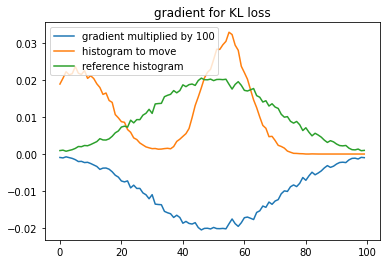

In [319]:
#x1 = torch.concat([torch.tensor(np.random.randn(10000)*10+np.random.randint(100))*(3/4),torch.tensor(np.random.randn(10000)*10+np.random.randint(100))]).float()
hist1 = hist_fun(f_rel,x1,2,100)
hist1/=hist1.sum()
hist1.requires_grad_(True)
#x2 = torch.Tensor(np.random.randn(20000)*20+50)
hist2 = hist_fun(f_rel,x2,2,100)/torch.numel(x2)
hist2 /= hist2.sum()


loss = nn.KLDivLoss()

l = loss(hist1,hist2)
l.backward()

plt.title("gradient for KL loss")
plt.plot(100.*hist1.grad,label="gradient multiplied by 100")
plt.plot(hist1.detach(),label="histogram to move")
plt.plot(hist2,label="reference histogram")
plt.legend()

2.4865748227283734e-14


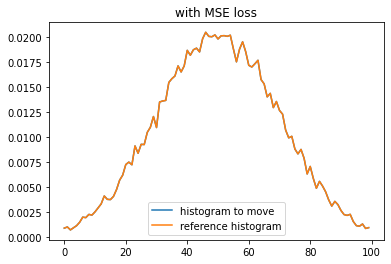

In [325]:
#basic gradient descent
loss = nn.MSELoss()

lr=0.1

for i in range(5000):

  hist1.requires_grad_(True)
  l = loss(hist1,hist2)
  
  l.backward()

  with torch.no_grad():
    hist1 = hist1 - lr * hist1.grad
    hist1 /= hist1.sum()
    hist1.grad=None
print(l.item())

plt.title("with MSE loss")
plt.plot(hist1.detach(),label="histogram to move")
plt.plot(hist2,label="reference histogram")
plt.legend()

Try it out on a KS-DIV problem (transform a histogram into another)
one image as input, totally overfit to this image. Turn the histogram into the desired one.

1.   plot the gradients through a MSE loss, ASE, KLDIV as well
2.   try gradient descent to turn one hist into another

converting image to lch, did 10000 pixels
converting image to lch, did 20000 pixels
converting image to lch, did 30000 pixels
converting image to lch, did 40000 pixels
converting image to lch, did 50000 pixels
converting image to lch, did 60000 pixels
converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


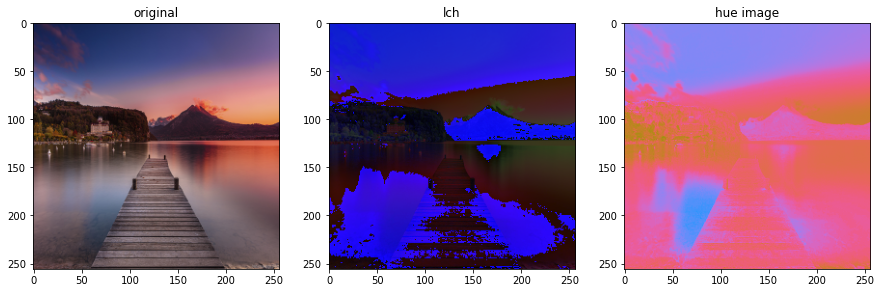

In [394]:
#load the image and convert to lch

img = np.array(Image.open("for_test.png"))
img_lch = rgb_to_lch(img,True)
img_h = h_to_rgb(img_lch[:,:,2],True)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("original")
plt.imshow(img)
plt.subplot(1,3,2)
plt.title("lch")
plt.imshow(img_lch/255.)
plt.subplot(1,3,3)
plt.title("hue image")
plt.imshow(img_h)

In [456]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    #encoding
    self.c1 = nn.Conv2d(1,50,3,2)
    self.c2 = nn.Conv2d(50,50,3,2,2)
    self.c3 = nn.Conv2d(50,50,3,1)

    self.dc1 = nn.ConvTranspose2d(50,50,3,2)
    self.dc2 = nn.ConvTranspose2d(50,50,4,2)
    self.dc3 = nn.ConvTranspose2d(50,1,3,1,padding=1)

  def forward(self,x):
    x = self.c1(x)
    x = nn.functional.relu(x)
    x = self.c2(x)
    x = nn.functional.relu(x)
    x = self.c3(x)
    x = nn.functional.relu(x)

    x = self.dc1(x)
    x = nn.functional.relu(x)
    x = self.dc2(x)
    x = nn.functional.relu(x)
    x = self.dc3(x)
    x = nn.functional.relu(x)
    return x

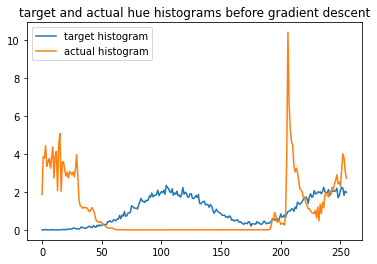

In [555]:
#ideal hue histogram
x = torch.concat([torch.tensor(np.random.randn(10000)*np.random.randint(60)+np.random.randint(256))*(3/4),torch.tensor(np.random.randn(10000)*np.random.randint(60)+np.random.randint(256))]).float()
hist_ideal = hist_fun(f_rel,x,2,256)
h = torch.Tensor(img_lch[:,:,2])
hist = hist_fun(f_rel,h,2,256)

hist_ideal/=hist_ideal.sum()/256.
hist/=hist.sum()/256.

plt.title("target and actual hue histograms before gradient descent")
plt.plot(hist_ideal,label="target histogram")
plt.plot(hist,label="actual histogram")
plt.legend()
plt.show()

In [567]:
#define variables
model = AutoEncoder()
opt = torch.optim.Adam(params=model.parameters(),lr=0.0001)
loss = nn.CrossEntropyLoss()

img_train = torch.Tensor(img_lch[:,:,2].reshape(1,256,256))

In [572]:
#gradient descent to give image the ideal histogram using our autoencoder
for i in range(1000):
  pred = model(img_train)
  histPred = hist_fun(f_rel,pred.reshape((torch.tensor(pred.shape).prod())),2,256)
  histPred /=histPred.sum()
  l = loss(histPred,hist_ideal/hist_ideal.sum())
  if i%5==0:
    print(l.item())

  opt.zero_grad()
  l.backward()
  opt.step()

5.542816638946533
5.542807102203369
5.5428080558776855
5.542793273925781
5.542802810668945
5.542795658111572
5.54278564453125
5.5427727699279785
5.542827606201172
5.54280424118042
5.542804718017578
5.542776584625244
5.542760848999023
5.542763710021973
5.542756080627441
5.542744159698486
5.542755126953125
5.542747974395752
5.542766094207764
5.542750358581543
5.542745590209961
5.542741298675537
5.542731285095215
5.54276180267334
5.54275369644165
5.542731761932373
5.542717933654785
5.542723178863525
5.5427374839782715
5.542720794677734
5.542729377746582
5.542758941650391
5.542730331420898
5.542724132537842
5.5427350997924805
5.542718887329102
5.542695999145508
5.54270601272583
5.542701244354248
5.542696952819824
5.542689800262451
5.542678356170654
5.542677879333496
5.542664527893066
5.542721748352051
5.542736053466797
5.542723178863525
5.542726516723633
5.54272985458374
5.5426859855651855
5.542693138122559
5.542747497558594
5.542708396911621
5.542673110961914
5.542657852172852
5.542639255

KeyboardInterrupt: ignored

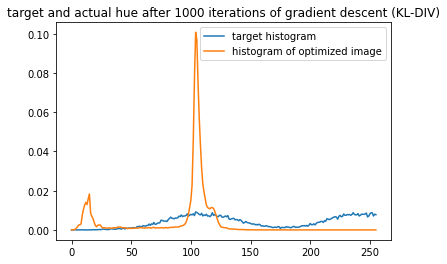

In [573]:
plt.title("target and actual hue after 1000 iterations of gradient descent (KL-DIV)")
plt.plot(hist_ideal/hist_ideal.sum(),label="target histogram")
plt.plot(histPred.detach(),label="histogram of optimized image")
plt.legend()
plt.show()

In [574]:
#make the prediction which has this "actual histogram" and convert the image to an rgb image
pred = model(img_train)
pred = h_to_rgb(pred.detach().reshape(256,256),True)
img_h_to_rgb = h_to_rgb(img_train.reshape(256,256),True)

converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels
converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


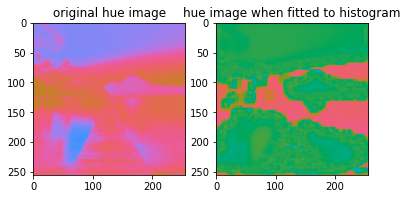

In [575]:
plt.figure()
plt.subplot(1,2,1)
plt.title("original hue image")
plt.imshow(torch.Tensor(img_h_to_rgb))
plt.subplot(1,2,2)
plt.title("hue image when fitted to histogram")
plt.imshow(pred)

In [576]:
#just out of curiosity, show the result with new hues
final_img = img_lch.copy()
final_img[:,:,2]=model(img_train).detach().reshape(256,256)
final_img_rgb = lch_to_rgb(final_img,True)

converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


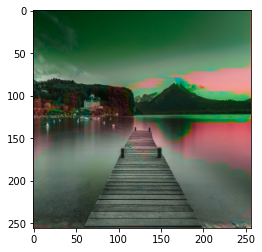

In [577]:
plt.imshow(final_img_rgb)